# Load raw dataset
A medium-sized dataset is provided (rather than 12 GB full dataset as is in AWS) for data wrangling in the spark cluster of IBM Watson Studio. 


In [1]:
# Load raw data to spark
# IBM Watson Studio is not free to use unlimited even for the lite version, I complete this project locally

import ibmos2spark, os
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.private.us.cloud-object-storage.appdomain.cloud',
    'service_id': 'iam-ServiceId-b314834d-5443-4359-8efa-88fb1ca94789',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'NfS0KqvIB-QZO6PoO6p1UYPdzthvM2t3mOeNGUatbbnC'
}

configuration_name = 'os_c4ce378e6d4243b4bee4d7f946ea0bff_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-crgpbxoft3rjye'))
df_data_1.take(5)

NameError: name 'sc' is not defined

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df_data_1 = spark.read.json('medium-sparkify-event-data.json')
df_data_1.take(5)

22/08/16 12:59:00 WARN Utils: Your hostname, MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.3.187 instead (on interface en0)
22/08/16 12:59:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/16 12:59:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

# Data cleanning and exploration 
In this section, data cleaning is completed including checking size of dataset, columns, invalid or missing data, drop duplicates, exploratory visualization, categorical data processing, and so forth. 

In [8]:
from pyspark.sql import Row, Window
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, StringType
import matplotlib.pyplot as plt
import pyspark.pandas as ps
import pandas as pd
import seaborn as sns
import numpy as np

In [4]:
df_data_1.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df_data_1.show()

+--------------------+----------+---------+------+-------------+---------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|      auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+----------+---------+------+-------------+---------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       Martin Orford| Logged In|   Joseph|     M|           20|  Morales|597.55057| free|  Corpus Christi, TX|   PUT|       NextSong|1532063507000|      292|       Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|   John Brown's Body| Logged In|   Sawyer|     M|           74|   Larson|380.21179|

In [6]:
print((df_data_1.count(), len(df_data_1.columns)))

(543705, 18)


In [8]:
df_pandas = df_data_1.toPandas()
df_pandas.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1.532064e+12,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1.538070e+12,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1.535953e+12,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1.535953e+12,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1.535931e+12,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246


In [9]:
df_pandas.auth.unique(), df_pandas.level.unique(), df_pandas.method.unique(), df_pandas.page.unique(), df_pandas.status.unique()

(array(['Logged In', 'Logged Out', 'Cancelled', 'Guest'], dtype=object),
 array(['free', 'paid'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Logout', 'Home', 'Login', 'Downgrade',
        'Add to Playlist', 'Roll Advert', 'Thumbs Up', 'Help',
        'Thumbs Down', 'Add Friend', 'About', 'Settings', 'Save Settings',
        'Upgrade', 'Submit Downgrade', 'Cancel',
        'Cancellation Confirmation', 'Submit Upgrade', 'Error', 'Register',
        'Submit Registration'], dtype=object),
 array([200, 307, 404]))

In [9]:
df_data_1.select('artist').distinct().count(), df_data_1.select('song').distinct().count(), df_data_1.select('itemInSession').distinct().count(), df_data_1.select('location').distinct().count(), \
 df_data_1.select('sessionId').distinct().count(), df_data_1.select('userId').distinct().count()

(21248, 80293, 1006, 193, 4590, 449)

In [11]:
df_pandas[df_pandas.userId == '']['userId'].count(), df_pandas[df_pandas.userId == '']['sessionId'].count()

(15700, 15700)

In [4]:
df_data_1 = df_data_1.filter(df_data_1.userId != '')
df_data_1.filter(df_data_1.userId == '').count(), df_data_1.filter(df_data_1.sessionId == '').count()

(0, 0)

In [5]:
df_pandas = df_data_1.toPandas()
df_data_1.select('artist').distinct().count(), df_data_1.select('song').distinct().count(), df_data_1.select('itemInSession').distinct().count(), df_data_1.select('location').distinct().count(), \
 df_data_1.select('sessionId').distinct().count(), df_data_1.select('userId').distinct().count()

(21248, 80293, 1006, 192, 4470, 448)

In [6]:
df_pandas.auth.unique(), df_pandas.level.unique(), df_pandas.method.unique(), df_pandas.page.unique(), df_pandas.status.unique()

(array(['Logged In', 'Cancelled'], dtype=object),
 array(['free', 'paid'], dtype=object),
 array(['PUT', 'GET'], dtype=object),
 array(['NextSong', 'Logout', 'Home', 'Downgrade', 'Add to Playlist',
        'Roll Advert', 'Thumbs Up', 'Help', 'Thumbs Down', 'Add Friend',
        'Settings', 'Save Settings', 'Upgrade', 'About',
        'Submit Downgrade', 'Cancel', 'Cancellation Confirmation',
        'Submit Upgrade', 'Error'], dtype=object),
 array([200, 307, 404]))

**Note**

We noticed that the when we cleaned the userId and sessionId, the auth column lost two values 'Logged Out', and 'Guest' and the page column lost some values too which are: 'Login', 'Register', and 'Submit Registration'

This is logical, as the users without a usedId, are either guests or logged out users. Only guests can Register, or Submit Registration, while only logged out users can  Login.

# Data Exploratory Analysis

Here we load a medium-sized dataset to work, but the code is scalable to full large dataset.

## Define Churn

Create a column "Churn" as the label, here we use "Cancellation Confirmation" events to define churn. We calculate churn for each userId, churn = 1 means this user churns.

In [9]:
cancellation_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_data_1 = df_data_1.withColumn('churn', cancellation_event('page'))
window = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df_data_1 = df_data_1.withColumn('churn', sum('churn').over(window))

In [10]:
df_data_1.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|              Darude|Logged In| Darianna|     F|            0|Carpenter|226.08934| free|Bridgeport-Stamfo...|   PUT|   NextSong|1538016340000|       62|           Sandstorm|   200|1538991392000|"Mozilla/5.0 (iPh...|100010|    1|
|             Justice|Logged In| Darianna|     F|            1|Carpenter|285.413

## Explore Data
Once we defined churn, perform exploratory analysis to find out who impacts churn.

In [11]:
# Count missing values for each column
# Since number of null rows is high, just keep those rows for now
df_data_1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_data_1.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|churn|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+
| 95128|   0|        0|     0|            0|       0| 95128|    0|       0|     0|   0|           0|        0|95129|     0|  0|        0|     0|    0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+-----+



In [12]:
df_data_1.drop_duplicates(['userId']).groupby(['churn']).count().show(), \
df_data_1.drop_duplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show(), \
df_data_1.drop_duplicates(['userId', 'level']).groupby(['level', 'churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  349|
|    1|   99|
+-----+-----+



+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|  153|
|    1|     M|   54|
|    1|     F|   45|
|    0|     M|  196|
+-----+------+-----+



+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  288|
| paid|    0|  246|
| free|    1|   82|
| paid|    1|   75|
+-----+-----+-----+



(None, None, None)

In [13]:
df_pandas = df_data_1.toPandas()

In [14]:
df_data_1.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



**Note**
There are 349 users stay while 99 churn.

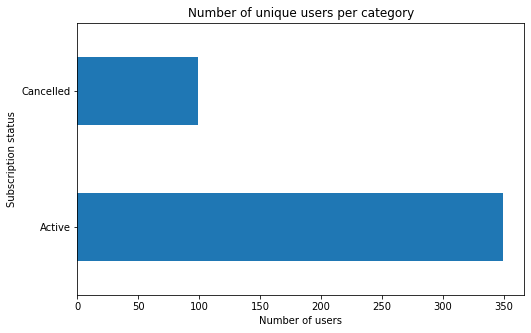

In [15]:
# Plot frequency

def plot_frequency(subset, group, labels, x_title = 'Number of users', y_title='Subscription status'):
    ax = df_pandas.drop_duplicates(subset = subset).groupby(group)['userId'].count().plot(
        kind = 'barh', figsize=(8,5), title='Number of unique users per category')
    
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_yticklabels(labels, rotation=0)

plot_frequency(['userId'], ['churn'], ['Active', 'Cancelled'])

There is a huge number of cancellation, about 25% of the users cancelled!

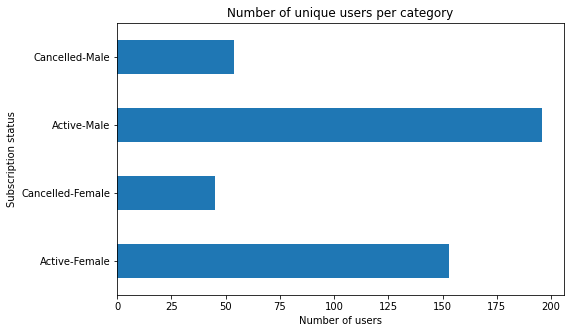

In [16]:
plot_frequency(['userId', 'gender'], ['gender', 'churn'], ['Active-Female', 'Cancelled-Female', 'Active-Male', 'Cancelled-Male'])

We see that more male users cancelled than females. Gender may affect churn.

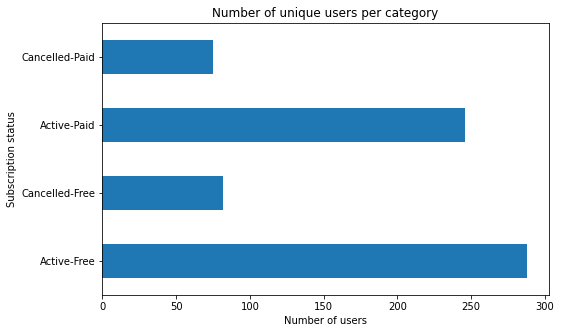

In [17]:
plot_frequency(['userId', 'level'], ['level', 'churn'], ['Active-Free', 'Cancelled-Free', 'Active-Paid', 'Cancelled-Paid'])

Free users cancelled the service slightly more than paid users. Level may impact less than gender on churn.

page
About                         0.959195
Add Friend                    7.969098
Add to Playlist              11.712552
Cancel                        0.513299
Cancellation Confirmation     0.513299
Downgrade                     4.308602
Error                         0.502929
Help                          2.680562
Home                         19.588324
Logout                        6.138850
Roll Advert                  11.334059
Save Settings                 0.539223
Settings                      3.209416
Submit Downgrade              0.150360
Submit Upgrade                0.362939
Thumbs Down                   5.993674
Thumbs Up                    22.294810
Upgrade                       1.228807
Name: userId, dtype: float64


Text(0.5, 1.0, 'Percent of envent occurence for active and cancelled users')

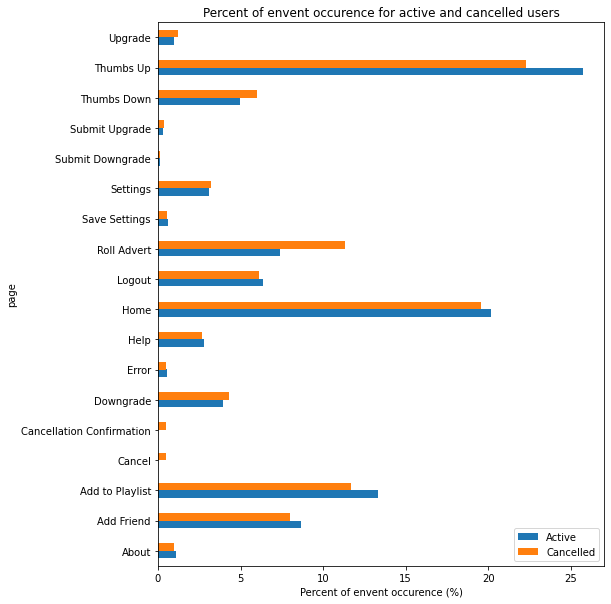

In [18]:
# Check the impact of page types on churn 
user_0 = df_pandas[df_pandas.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')
user_0 = 100 * user_0 /user_0.sum()

user_1 = df_pandas[df_pandas.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
user_1 = 100 * user_1 /user_1.sum()
print(user_1)

df_users = pd.DataFrame({'Active': user_0, 'Cancelled': user_1})
ax = df_users.plot(kind = 'barh', figsize = (8, 10))
ax.set_xlabel('Percent of envent occurence (%)')
ax.set_title('Percent of envent occurence for active and cancelled users')

It looks like people reviewing roll advert are more likely to cancel. Also, thumbs down users are more likely to cancel. 

## Time analysis 

In [19]:
import datetime


get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))


In [20]:
funcs = {'hour': get_hour,'day':get_day, 'month':get_month, 'week_day':get_weekday }
for label, func in funcs.items():
    df_data_1 = df_data_1.withColumn(label, func(df_data_1.ts))
    print(f'Column {label} add successfully!')

Column hour add successfully!
Column day add successfully!
Column month add successfully!
Column week_day add successfully!


In [21]:
df_p = df_data_1.toPandas()

In [23]:
df_p.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,churn,hour,day,month,week_day
0,Darude,Logged In,Darianna,F,0,Carpenter,226.08934,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,Sandstorm,200,1538991392000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1
1,Justice,Logged In,Darianna,F,1,Carpenter,285.41342,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,Phantom Part 1.5 (Album Version),200,1538991618000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1
2,Five Iron Frenzy,Logged In,Darianna,F,2,Carpenter,236.09424,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,Canada,200,1538991903000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1
3,Carpenters,Logged In,Darianna,F,3,Carpenter,250.25261,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,Ticket To Ride,200,1538992139000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1
4,Uffie,Logged In,Darianna,F,4,Carpenter,227.52608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,Dismissed (Uffie),200,1538992389000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1


In [22]:
def get_user_time(time, churn):

    user_time = df_p[df_p.churn == churn].groupby(time)['userId'].count()
    perc_time = 100 * user_time / user_time.sum()
    try:
        perc_time.index = perc_time.index.astype(int)
    except:
        pass
    return perc_time.sort_index()


def plot_time_dist(time, figsize=(15,4), title=None, label_rotation=0):

    df_time = pd.DataFrame({'Cancelled': get_user_time(time, 1), 'Active': get_user_time(time, 0)})
    ax = df_time.plot(kind='bar', figsize=figsize)
    ax.set_ylabel('Percent of users')
    if title == None:
        title = time
    ax.set_ylabel(f'Percent of users')
    #print(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=label_rotation)
    ax.set_title(f'Percent of users took action per {title}') 
    return ax

<AxesSubplot:title={'center':'Percent of users took action per hour of the day'}, xlabel='hour', ylabel='Percent of users'>

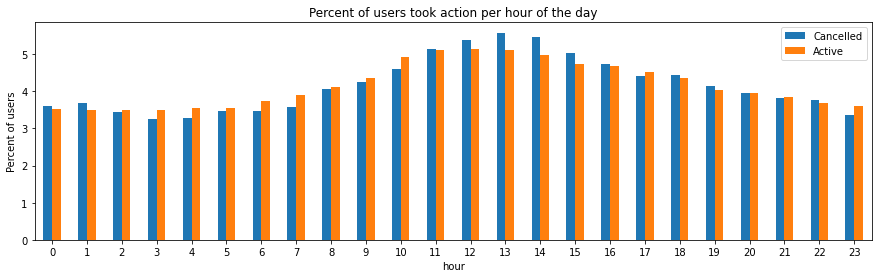

In [23]:
plot_time_dist('hour', title = 'hour of the day')

It looks like the number of active and churn users are pretty close for each hour, except for between 13:00 and 16:00 when more users churn.

<AxesSubplot:title={'center':'Percent of users took action per month'}, xlabel='month', ylabel='Percent of users'>

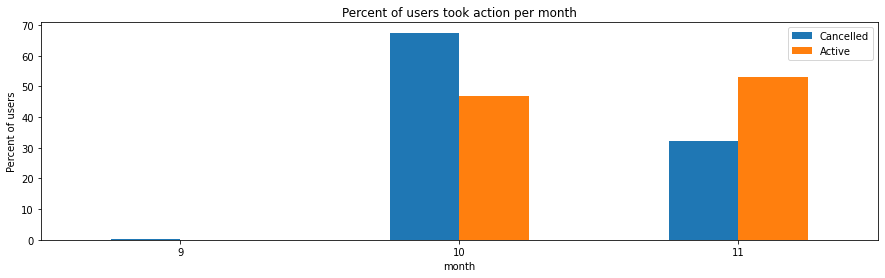

In [24]:
plot_time_dist('month', title = 'month')

Obviously, more users churned in October. Month significantly impacts churn rate.

<AxesSubplot:title={'center':'Percent of users took action per day'}, xlabel='day', ylabel='Percent of users'>

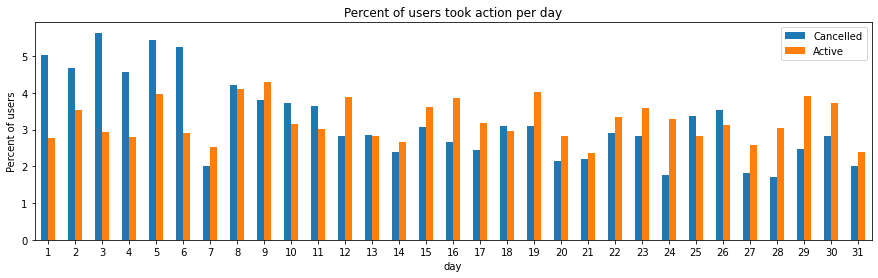

In [25]:
plot_time_dist('day', title = 'day')

More users walked away at the beginning of the month.

[Text(0, 0, 'Mon'),
 Text(1, 0, 'Tue'),
 Text(2, 0, 'Wed'),
 Text(3, 0, 'Thu'),
 Text(4, 0, 'Fri'),
 Text(5, 0, 'Sat'),
 Text(6, 0, 'Sun')]

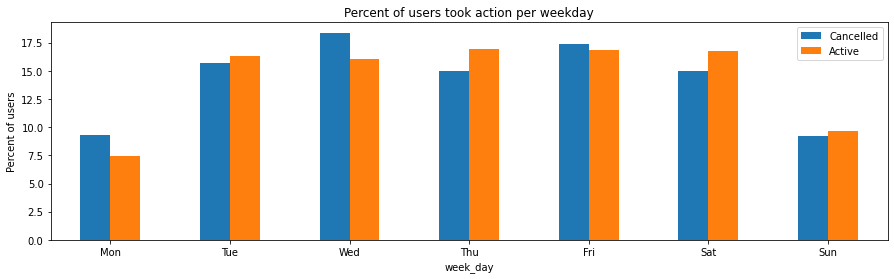

In [26]:
ax = plot_time_dist('week_day', title = 'weekday')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)

More churn happened on Mon, Wed, Fri. 

## Check categorical variables

1. User agent

In [27]:
df_p.userAgent.unique().shape[0]

71

In [40]:
agents = [x.strip() for x  in df_p.userAgent.unique() if x is not None] 

In [43]:
sorted(list(set(x[x.find('(') + 1:x.find(')')].split(';')[0].capitalize() for x in agents)))

['Compatible',
 'Ipad',
 'Iphone',
 'Macintosh',
 'Windows nt 5.1',
 'Windows nt 6.0',
 'Windows nt 6.1',
 'Windows nt 6.2',
 'Windows nt 6.3',
 'X11']

In [44]:
# Create general categories for user agent
sys_general = {'Compatible': 'Windows', 'Ipad': 'iOS', 'Iphone': 'iOS', 'Macintosh': 'Mac', 
                'Windows nt 5.1': 'Windows','Windows nt 6.0': 'Windows', 'Windows nt 6.1': 'Windows',
                'Windows nt 6.2': 'Windows', 'Windows nt 6.3': 'Windows', 'X11': 'Linux'}

get_sys = udf(lambda x: sys_general[x[x.find('(') + 1:x.find(')')].split(';')[0].capitalize()])
df_data_1 = df_data_1.withColumn('computer_systems', get_sys(df_data_1.userAgent))
df_data_1.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----+---+-----+--------+----------------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|hour|day|month|week_day|computer_systems|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----+---+-----+--------+----------------+
|              Darude|Logged In| Darianna|     F|            0|Carpenter|226.08934| free|Bridgeport-Stamfo...|   PUT|   NextSong|1538016340000|       62|           Sandstorm|   200|153899

2. Location \
We only consider state.

In [45]:
df_p.location.unique().shape[0]

192

In [47]:
df_p.location.unique()

array(['Bridgeport-Stamford-Norwalk, CT',
       'New York-Newark-Jersey City, NY-NJ-PA',
       'Dallas-Fort Worth-Arlington, TX', 'Denver-Aurora-Lakewood, CO',
       'Providence-Warwick, RI-MA', 'Muncie, IN',
       'Vineland-Bridgeton, NJ', 'Corpus Christi, TX', 'Morgantown, WV',
       'San Francisco-Oakland-Hayward, CA',
       'Chicago-Naperville-Elgin, IL-IN-WI',
       'Lafayette-West Lafayette, IN', 'Seattle-Tacoma-Bellevue, WA',
       'Columbus, GA-AL', 'Boston-Cambridge-Newton, MA-NH',
       'Ottawa-Peru, IL', 'New Orleans-Metairie, LA',
       'Charlotte-Concord-Gastonia, NC-SC',
       'Los Angeles-Long Beach-Anaheim, CA',
       'Allentown-Bethlehem-Easton, PA-NJ', 'Ionia, MI',
       'Detroit-Warren-Dearborn, MI', 'Indianapolis-Carmel-Anderson, IN',
       'Danville, VA', 'Lexington-Fayette, KY',
       'Spokane-Spokane Valley, WA', 'Milwaukee-Waukesha-West Allis, WI',
       'Houston-The Woodlands-Sugar Land, TX', 'Wichita, KS',
       'Miami-Fort Lauderdale-West Pal

In [49]:
get_state = udf(lambda x: x.split(',')[1].strip())
df_data_1 = df_data_1.withColumn('State', get_state(df_data_1.location))
df_data_1.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----+---+-----+--------+----------------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|hour|day|month|week_day|computer_systems|State|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----+---+-----+--------+----------------+-----+
|              Darude|Logged In| Darianna|     F|            0|Carpenter|226.08934| free|Bridgeport-Stamfo...|   PUT|   NextSong|1538016340000|       62|           Sands

In [50]:
df_p = df_data_1.toPandas()
df_p.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,ts,userAgent,userId,churn,hour,day,month,week_day,computer_systems,State
0,Darude,Logged In,Darianna,F,0,Carpenter,226.08934,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538991392000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1,iOS,CT
1,Justice,Logged In,Darianna,F,1,Carpenter,285.41342,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538991618000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1,iOS,CT
2,Five Iron Frenzy,Logged In,Darianna,F,2,Carpenter,236.09424,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538991903000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1,iOS,CT
3,Carpenters,Logged In,Darianna,F,3,Carpenter,250.25261,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538992139000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1,iOS,CT
4,Uffie,Logged In,Darianna,F,4,Carpenter,227.52608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538992389000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,1,5,8,10,1,iOS,CT


<AxesSubplot:title={'center':'Percent of users took action per computer_systems'}, xlabel='computer_systems', ylabel='Percent of users'>

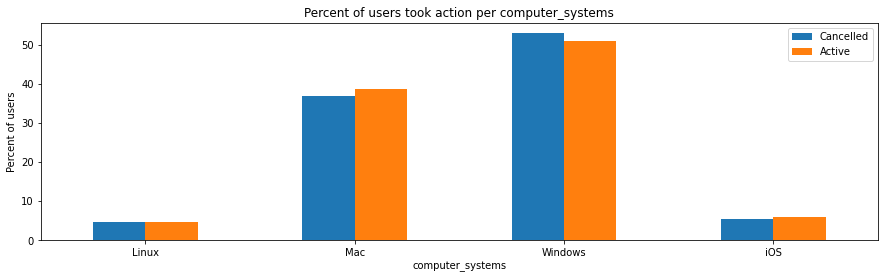

In [52]:
plot_time_dist('computer_systems')

It seems that Mac users are more willing to be active than Windows users, but the impact is not significant visually.

<AxesSubplot:title={'center':'Percent of users took action per State'}, xlabel='State', ylabel='Percent of users'>

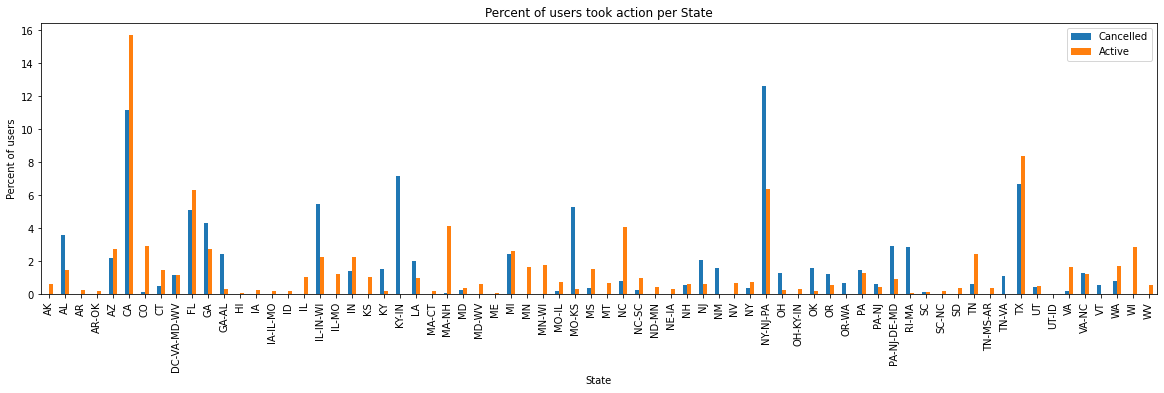

In [55]:
plot_time_dist('State', figsize=(20,5), label_rotation=90)

In [57]:
df_data_1.select('State').distinct().count()

70

In [58]:
df_data_1.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----+---+-----+--------+----------------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|hour|day|month|week_day|computer_systems|State|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+----+---+-----+--------+----------------+-----+
|              Darude|Logged In| Darianna|     F|            0|Carpenter|226.08934| free|Bridgeport-Stamfo...|   PUT|   NextSong|1538016340000|       62|           Sands

# Feature engineering
We have completed data exploratory based on which many features would be kept:

- Gender
- payment level (free and paid)
- Used computer system (userAgent)
- location (State)
- Number of thumbs up/down
- Number of downgrades
- Number of roll advert
- time-related variables: Session duration, user's subscription age, ......

We need to create a user-customized table as the modeling dataset.

In [106]:
churn_users = df_data_1.select('userId', 'churn').dropDuplicates()
churn_users.count()

448

In [100]:
def get_dummy(column, val):
    
    df_data_2 = df_data_1.select('userId', column).dropDuplicates()
    df = df_data_2.withColumn(f'{column}_num', when(col(column) == val, 1).otherwise(0)).select('userId', col(f'{column}_num').cast('int'))
    print(df.printSchema(), df.show(3))

    return df

In [103]:
gender_df = get_dummy('gender', 'M')
gender_df.count()

root
 |-- userId: string (nullable = true)
 |-- gender_num: integer (nullable = false)



+------+----------+
|userId|gender_num|
+------+----------+
|   234|         1|
|   188|         0|
|   273|         1|
+------+----------+
only showing top 3 rows

None None


448

In [104]:
level_df = get_dummy('level', 'paid')

root
 |-- userId: string (nullable = true)
 |-- level_num: integer (nullable = false)

+------+---------+
|userId|level_num|
+------+---------+
|   185|        0|
|   207|        0|
|     6|        0|
+------+---------+
only showing top 3 rows

None None


In [114]:
# Create dummy variables for computer_systems and state
def dummy_sys_state(column_name):

    sys_list = df_data_1.select(column_name).distinct().rdd.flatMap(lambda x: x).collect()
    list_exp = [when(col(column_name) == x, 1).otherwise(0).alias(x) for x in sys_list]
    df = df_data_1.select('userId', *list_exp)
    df.show(10)

    return df

In [116]:
sys_df = dummy_sys_state('computer_systems')

+------+---+-----+---+-------+
|userId|iOS|Linux|Mac|Windows|
+------+---+-----+---+-------+
|   293|  0|    0|  1|      0|
|    98|  0|    0|  1|      0|
|   179|  0|    0|  1|      0|
|   179|  0|    0|  1|      0|
|   246|  0|    0|  0|      1|
|   163|  0|    0|  1|      0|
|   179|  0|    0|  1|      0|
|   175|  0|    0|  1|      0|
|   100|  0|    0|  0|      1|
|   100|  0|    0|  0|      1|
+------+---+-----+---+-------+
only showing top 10 rows



In [118]:
loc_df = dummy_sys_state('State')

+------+---+---+-----+---+---+-----+-----+---+-----+-----+---+-----+-----+-----+---+--------+---+---+---+---+---+---+---+---+---+---+-----+---+-----+---+---+---+---+---+-----+---+---+---+---+---+-----------+---+-----+-----+-----------+---+-----+---+--------+--------+---+-----+---+---+---+-----+---+--------+-----+---+-----+--------+---+---+---+---+-----+---+-----+---+
|userId| AZ| SC|GA-AL| LA| MN|RI-MA|MA-CT| NJ|IL-MO|MN-WI| OR|PA-NJ|SC-NC|MD-WV| VA|NY-NJ-PA| KY| NH| MI| NV| WI| CA| CT| MT| NC| MD|NE-IA| IL|ND-MN| ME| WA| MS| AL| IN|AR-OK| OH| TN| NM| PA| SD|DC-VA-MD-WV| NY|MO-KS|KY-IN|PA-NJ-DE-MD| TX|VA-NC| GA|IL-IN-WI|OH-KY-IN| KS|MO-IL| FL| CO| AK|MA-NH| OK|TN-MS-AR|TN-VA| UT|NC-SC|IA-IL-MO| IA| WV| ID| VT|OR-WA| AR|UT-ID| HI|
+------+---+---+-----+---+---+-----+-----+---+-----+-----+---+-----+-----+-----+---+--------+---+---+---+---+---+---+---+---+---+---+-----+---+-----+---+---+---+---+---+-----+---+---+---+---+---+-----------+---+-----+-----+-----------+---+-----+---+--------+--

In [120]:
loc_df.dropDuplicates().count()

448

**Number of page events**

In [146]:
user_page_distribution = df_data_1.groupby('userId').pivot('page').count().na.fill(0) 
drop_col = ['Cancel', 'Cancellation Confirmation']
user_page_distribution = user_page_distribution.drop(*drop_col)

In [168]:

# Normalize each row sum to 1
page_cols = user_page_distribution.columns[1:]
rowsum = user_page_distribution.withColumn('rowsum',sum([col(c) for c in page_cols]))

AttributeError: 'DataFrame' object has no attribute 'sum'

## 3. Data exploration

In [18]:
df_cleaned.show()

+---------+------+-------------+-----+--------------------+------+---------+------+-------------+--------------------+------+-----+
|     auth|gender|itemInSession|level|            location|method|sessionId|status|           ts|           userAgent|userId|Churn|
+---------+------+-------------+-----+--------------------+------+---------+------+-------------+--------------------+------+-----+
|Logged In|     M|           17| free|New York-Newark-J...|   PUT|      485|   307|1538358281000|"Mozilla/5.0 (Mac...|   273|    0|
|Logged In|     M|           32| free|Dallas-Fort Worth...|   PUT|      497|   200|1538358545000|Mozilla/5.0 (Wind...|   100|    0|
|Logged In|     M|           27| free|New York-Newark-J...|   GET|      485|   200|1538359820000|"Mozilla/5.0 (Mac...|   273|    0|
|Logged In|     M|           76| free|  Corpus Christi, TX|   PUT|      292|   200|1538362379000|"Mozilla/5.0 (Mac...|   293|    0|
|Logged In|     M|           11| free|Kingsport-Bristol...|   PUT|      487|

99

### 3.1 Check how userAgent and location relate to churn
The histogram of number of user agents and locations are consistent between churn 1 and churn 0, which demonstrates that churn behavior is also unrelated to these two factors. So we drop these two columns as well. 

In [20]:
df_1 = df_cleaned.groupBy('Churn', 'userAgent').count().filter(df_cleaned.Churn == 1).toPandas().rename(columns={"count": "count_1"})
df_0 = df_cleaned.groupBy('Churn', 'userAgent').count().filter(df_cleaned.Churn == 0).toPandas().rename(columns={"count": "count_0"})
df_combined = pd.concat([df_1['count_1'], df_0['count_0']], axis = 1)
df_combined['count_1'] = (df_combined['count_1'] - df_combined['count_1'].min()) / (df_combined['count_1'].max() - df_combined['count_1'].min())
df_combined['count_0'] = (df_combined['count_0'] - df_combined['count_0'].min()) / (df_combined['count_0'].max() - df_combined['count_0'].min())
df_combined.head()

,count_1,count_0
0,0.0,0.037888
1,0.2,0.077414
2,0.0,0.206997
3,0.5,0.039831
4,0.4,0.144214


Text(0, 0.5, 'Frequency')

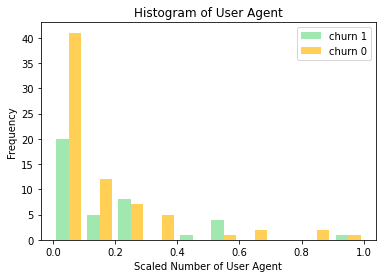

In [21]:
plt.hist(df_combined, color=['#A0E8AF', '#FFCF56'])
plt.legend(['churn 1', 'churn 0'])
plt.title('Histogram of User Agent')
plt.xlabel('Scaled Number of User Agent')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

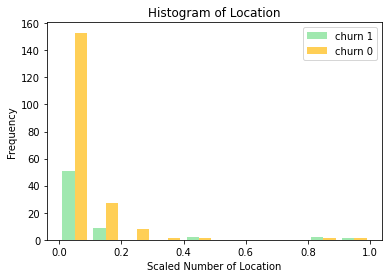

In [22]:
df_1 = df_cleaned.groupBy('Churn', 'location').count().filter(df_cleaned.Churn == 1).toPandas().rename(columns={"count": "count_1"})
df_0 = df_cleaned.groupBy('Churn', 'location').count().filter(df_cleaned.Churn == 0).toPandas().rename(columns={"count": "count_0"})
df_combined = pd.concat([df_1['count_1'], df_0['count_0']], axis = 1)
df_combined['count_1'] = (df_combined['count_1'] - df_combined['count_1'].min()) / (df_combined['count_1'].max() - df_combined['count_1'].min())
df_combined['count_0'] = (df_combined['count_0'] - df_combined['count_0'].min()) / (df_combined['count_0'].max() - df_combined['count_0'].min())

plt.hist(df_combined, color=['#A0E8AF', '#FFCF56'])
plt.legend(['churn 1', 'churn 0'])
plt.title('Histogram of Location')
plt.xlabel('Scaled Number of Location')
plt.ylabel('Frequency')

In [23]:
# Drop unused columns
df_cleaned = df_cleaned.drop('location', 'userAgent')
df_cleaned.show()

+---------+------+-------------+-----+------+---------+------+-------------+------+-----+
|     auth|gender|itemInSession|level|method|sessionId|status|           ts|userId|Churn|
+---------+------+-------------+-----+------+---------+------+-------------+------+-----+
|Logged In|     M|           17| free|   PUT|      485|   307|1538358281000|   273|    0|
|Logged In|     M|           32| free|   PUT|      497|   200|1538358545000|   100|    0|
|Logged In|     M|           27| free|   GET|      485|   200|1538359820000|   273|    0|
|Logged In|     M|           76| free|   PUT|      292|   200|1538362379000|   293|    0|
|Logged In|     M|           11| free|   PUT|      487|   200|1538368016000|   131|    0|
|Logged In|     M|           64| free|   PUT|      249|   200|1538375165000|   250|    0|
|Logged In|     M|           19| free|   PUT|      529|   200|1538376380000|   207|    0|
|Logged In|     M|          317| paid|   PUT|      178|   307|1538378914000|   179|    0|
|Logged In

### 3.2 Process date time

In [24]:
df_cleaned = df_cleaned.withColumn('date' ,from_unixtime(col('ts'), 'yyyy-MM-dd'))
df_cleaned = df_cleaned.withColumn('time', from_unixtime(col('ts'), "HH:mm:ss"))
df_cleaned.show()

+---------+------+-------------+-----+------+---------+------+-------------+------+-----+------------+--------+
|     auth|gender|itemInSession|level|method|sessionId|status|           ts|userId|Churn|        date|    time|
+---------+------+-------------+-----+------+---------+------+-------------+------+-----+------------+--------+
|Logged In|     M|           17| free|   PUT|      485|   307|1538358281000|   273|    0|+50718-08-20|12:43:20|
|Logged In|     M|           32| free|   PUT|      497|   200|1538358545000|   100|    0|+50718-08-23|14:03:20|
|Logged In|     M|           27| free|   GET|      485|   200|1538359820000|   273|    0|+50718-09-07|08:13:20|
|Logged In|     M|           76| free|   PUT|      292|   200|1538362379000|   293|    0|+50718-10-06|23:03:20|
|Logged In|     M|           11| free|   PUT|      487|   200|1538368016000|   131|    0|+50718-12-11|03:53:20|
|Logged In|     M|           64| free|   PUT|      249|   200|1538375165000|   250|    0|+50719-03-03|21

In [25]:
# It is meaningful to study churn behavior by day of week, but we cannot get correct date format based on timestamp in the ts column, so we don't use date in this project
# It might be useful to study hourly churn behavior but not on minute or second basis
df_cleaned = df_cleaned.withColumn('hours', split(df_cleaned['time'], ':').getItem(0))

# Drop the columns not to use
df_cleaned = df_cleaned.drop('date', 'time')
df_cleaned.show()

+---------+------+-------------+-----+------+---------+------+-------------+------+-----+-----+
|     auth|gender|itemInSession|level|method|sessionId|status|           ts|userId|Churn|hours|
+---------+------+-------------+-----+------+---------+------+-------------+------+-----+-----+
|Logged In|     M|           17| free|   PUT|      485|   307|1538358281000|   273|    0|   12|
|Logged In|     M|           32| free|   PUT|      497|   200|1538358545000|   100|    0|   14|
|Logged In|     M|           27| free|   GET|      485|   200|1538359820000|   273|    0|   08|
|Logged In|     M|           76| free|   PUT|      292|   200|1538362379000|   293|    0|   23|
|Logged In|     M|           11| free|   PUT|      487|   200|1538368016000|   131|    0|   03|
|Logged In|     M|           64| free|   PUT|      249|   200|1538375165000|   250|    0|   21|
|Logged In|     M|           19| free|   PUT|      529|   200|1538376380000|   207|    0|   00|
|Logged In|     M|          317| paid|  

In [26]:
df_cleaned_df = ps.DataFrame(df_cleaned).to_pandas()


/Volumes/work/Course Lecture/Udacity/DataScientistNanodegree/.venv/lib/python3.9/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


<AxesSubplot:xlabel='auth', ylabel='Churn'>

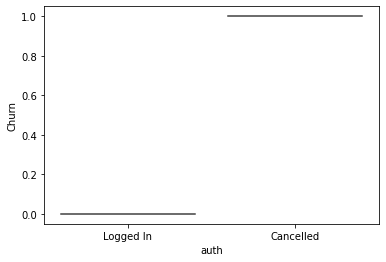

In [27]:
sns.violinplot(x = 'auth', y = 'Churn', data = df_cleaned_df)

<AxesSubplot:xlabel='gender', ylabel='Churn'>

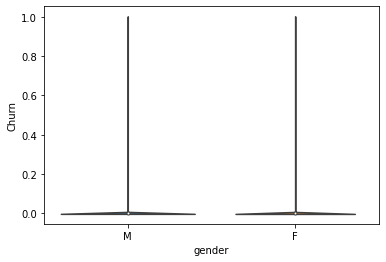

In [28]:
sns.violinplot(x = 'gender', y = 'Churn', data = df_cleaned_df)

<AxesSubplot:xlabel='level', ylabel='Churn'>

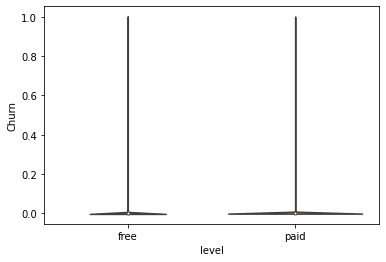

In [29]:
sns.violinplot(x = 'level', y = 'Churn', data = df_cleaned_df)

<AxesSubplot:xlabel='method', ylabel='Churn'>

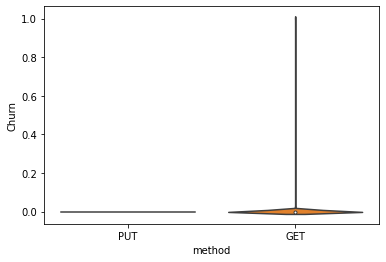

In [30]:
sns.violinplot(x = 'method', y = 'Churn', data = df_cleaned_df)

The violinplots above demonstrate that gender and level have little impact on churn, while auth and method may be more related. So we drop the columns "gender" and "level".

In [61]:
df_cleaned = df_cleaned.drop('gender', 'level')

df_cleaned.show()


+-------------+---------+------+------+-----+-----+----------+--------+
|itemInSession|sessionId|status|userId|Churn|hours|method_num|auth_num|
+-------------+---------+------+------+-----+-----+----------+--------+
|           17|      485|   307|   273|    0|   12|         1|       0|
|           32|      497|   200|   100|    0|   14|         1|       0|
|           27|      485|   200|   273|    0|   08|         0|       0|
|           76|      292|   200|   293|    0|   23|         1|       0|
|           11|      487|   200|   131|    0|   03|         1|       0|
|           64|      249|   200|   250|    0|   21|         1|       0|
|           19|      529|   200|   207|    0|   00|         1|       0|
|          317|      178|   307|   179|    0|   08|         1|       0|
|           37|      493|   200|    51|    0|   03|         1|       0|
|          119|       27|   200|    28|    0|   06|         0|       0|
|           96|      492|   200|    95|    0|   22|         1|  

22/08/15 17:34:22 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1827880 ms exceeds timeout 120000 ms
22/08/15 17:34:22 WARN SparkContext: Killing executors is not supported by current scheduler.
22/08/16 07:16:37 WARN TransportChannelHandler: Exception in connection from /192.168.3.109:52672
java.io.IOException: Operation timed out
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:223)
	at sun.nio.ch.IOUtil.read(IOUtil.java:192)
	at sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:378)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:258)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:350)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channe

### 3.3 Process categorical variables

In [32]:
df_cleaned = df_cleaned.withColumn('method_num', when(df_cleaned.method == 'PUT', 1).otherwise(0)).drop('method', 'ts')
df_cleaned = df_cleaned.withColumn('auth_num', when(df_cleaned.auth == 'Cancelled', 1).otherwise(0)).drop('auth')
df_cleaned.show()

+-------------+---------+------+------+-----+-----+----------+--------+
|itemInSession|sessionId|status|userId|Churn|hours|method_num|auth_num|
+-------------+---------+------+------+-----+-----+----------+--------+
|           17|      485|   307|   273|    0|   12|         1|       0|
|           32|      497|   200|   100|    0|   14|         1|       0|
|           27|      485|   200|   273|    0|   08|         0|       0|
|           76|      292|   200|   293|    0|   23|         1|       0|
|           11|      487|   200|   131|    0|   03|         1|       0|
|           64|      249|   200|   250|    0|   21|         1|       0|
|           19|      529|   200|   207|    0|   00|         1|       0|
|          317|      178|   307|   179|    0|   08|         1|       0|
|           37|      493|   200|    51|    0|   03|         1|       0|
|          119|       27|   200|    28|    0|   06|         0|       0|
|           96|      492|   200|    95|    0|   22|         1|  

In [33]:
df_cleaned_ps = ps.DataFrame(df_cleaned)
df_cleaned_ps['userId'] = df_cleaned_ps['userId'].astype(int)
df_cleaned_ps['hours'] = df_cleaned_ps['hours'].astype(int)
df_cleaned_ps.dtypes

itemInSession    int64
sessionId        int64
status           int64
userId           int64
Churn            int32
hours            int64
method_num       int32
auth_num         int32
dtype: object

### Important notes
Based on the heatmapping result below, there are three features related to churn rate, namely status, method, and auth. We remove those unrelated. 

/Volumes/work/Course Lecture/Udacity/DataScientistNanodegree/.venv/lib/python3.9/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


<AxesSubplot:>

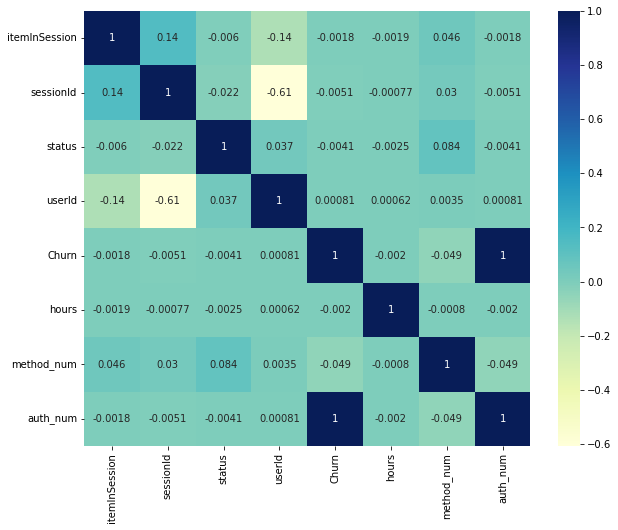

In [34]:
data_corr = df_cleaned_ps.to_pandas().corr()
plt.figure(figsize=(10, 8))
sns.heatmap(data_corr, cmap="YlGnBu", annot=True, xticklabels=True)

In [35]:
df_cleaned_ps = df_cleaned_ps.drop(['itemInSession', 'sessionId', 'userId', 'hours', 'status', 'method_num'], axis = 1)
df_cleaned_ps.head()

,Churn,auth_num
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


### 3.4 Save the processed data for modeling later

In [36]:
df_cleaned_df = df_cleaned_ps.to_pandas()
df_cleaned_df.to_json('churn_modeling_data.json', orient='records')

/Volumes/work/Course Lecture/Udacity/DataScientistNanodegree/.venv/lib/python3.9/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [37]:
df_cleaned_df[df_cleaned_df.Churn == 1].shape[0] / df_cleaned_df.shape[0]

0.00018767701354686808

# Modeling to predict Churn rate

## 1. Load training data

In [38]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.inspection import permutation_importance
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import f1_score

In [40]:
dataset = spark.read.json('churn_modeling_data.json')
dataset.show()

+-----+--------+
|Churn|auth_num|
+-----+--------+
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
|    0|       0|
+-----+--------+
only showing top 20 rows



## 2. Train the model

In [41]:
# Assemble features
assembler = VectorAssembler(inputCols=['auth_num'], outputCol='features')
output = assembler.transform(dataset)
model_data = output.select('features', col('Churn').alias('label'))

In [42]:
# Split training data into training and validation sets
train, test = model_data.randomSplit([0.9, 0.1], seed=42)
train.show()

+--------+-----+
|features|label|
+--------+-----+
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
|   [0.0]|    0|
+--------+-----+
only showing top 20 rows



In [43]:
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0.0)
pipeline = Pipeline(stages=[lr])

paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.5, 0.9]).addGrid(lr.elasticNetParam, [0.0, 0.5, 0.9]).build()

crossval = CrossValidator(estimator=pipeline,
                         estimatorParamMaps=paramGrid,
                         evaluator=BinaryClassificationEvaluator(),
                         numFolds=10)

cvModel = crossval.fit(train)

22/08/15 15:04:33 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
22/08/15 15:04:34 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


22/08/15 15:04:50 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed


22/08/15 15:05:01 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
22/08/15 15:05:02 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


22/08/15 15:05:07 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
22/08/15 15:05:08 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


22/08/15 15:05:21 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
22/08/15 15:05:22 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


22/08/15 15:05:35 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
22/08/15 15:05:36 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


22/08/15 15:05:49 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed


22/08/15 15:06:04 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
22/08/15 15:06:05 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


22/08/15 15:06:19 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
22/08/15 15:06:19 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


22/08/15 15:06:34 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
22/08/15 15:06:35 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


22/08/15 15:06:49 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
22/08/15 15:06:49 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


22/08/15 15:07:03 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
22/08/15 15:07:04 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


In [44]:
cv_pred = cvModel.bestModel.transform(test).select(col('label').cast('float'), 'prediction')
predictionAndLabels = cv_pred.rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
metrics.areaUnderPR  # areaUnderRP is actually recall


/Volumes/work/Course Lecture/Udacity/DataScientistNanodegree/.venv/lib/python3.9/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


0.0

In [47]:
true_positive = cv_pred.filter((cv_pred.label == 1) & (cv_pred.label == cv_pred.prediction)).count()
false_positive = cv_pred.filter((cv_pred.label == 0) & (cv_pred.label != cv_pred.prediction)).count()
false_negative = cv_pred.filter((cv_pred.label == 1) & (cv_pred.label != cv_pred.prediction)).count()
print(true_positive, false_positive, false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
f1 = 2*precision*recall / (precision + recall)


0 0 9


ZeroDivisionError: division by zero

In [379]:
# Use RandomForest to predict churn
Rf = RandomForestClassifier(maxDepth=5, numTrees=2)
pipeline_rf = Pipeline(stages=[Rf])
paramGrid_rf = ParamGridBuilder().addGrid(Rf.maxDepth, [5, 10]).addGrid(Rf.numTrees, [10, 20]).build()

crossval_rf = CrossValidator(estimator=pipeline_rf,
                         estimatorParamMaps=paramGrid_rf,
                         evaluator=BinaryClassificationEvaluator(),
                         numFolds=10)

cvModel_rf = crossval_rf.fit(train)

In [381]:
cv_pred_rf = cvModel_rf.bestModel.transform(test).select(col('label').cast('float'), 'prediction')
metrics_rf = BinaryClassificationMetrics(cv_pred_rf.rdd)
metrics_rf.areaUnderPR

0.0

In [382]:
true_positive = cv_pred_rf.filter((cv_pred_rf.label == 1) & (cv_pred_rf.label == cv_pred_rf.prediction)).count()
false_positive = cv_pred_rf.filter((cv_pred_rf.label == 0) & (cv_pred_rf.label != cv_pred_rf.prediction)).count()
false_negative = cv_pred_rf.filter((cv_pred_rf.label == 1) & (cv_pred_rf.label != cv_pred_rf.prediction)).count()
print(true_positive, false_positive, false_negative)


0 0 915
